In [2]:
import tensorflow as tf

In [43]:
from tensorflow import keras
import pandas as pd

In [4]:
with tf.Session() as sess:
  devices = sess.list_devices()

In [5]:
devices

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 16801597535488492107),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 16385653120678991329),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7219833816017096914),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 11330115994, 12196135550537985882)]

In [19]:
tf.__version__

'1.14.0'

In [20]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
#tf.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Autoencoders

In [9]:

np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [6]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))

W1111 22:19:49.349191 139920233404224 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 8         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
60/60 [==============================] - 51s 850ms/sample - loss: 1.3578
Epoch 2/20
60/60 [==============================] - 0s 80us/sample - loss: 0.7163
Epoch 3/20
60/60 [==============================] - 0s 93us/sample - loss: 0.4846
Epoch 4/20
60/60 [==============================] - 0s 106us/sample - loss: 0.3904
Epoch 5/20
60/60 [==============================] - 0s 81us/sample - loss: 0.3366
Epoch 6/20
60/60 [==============================] - 0s 84us/sample - loss: 0.3088
Epoch 7/20
60/60 [==============================] - 0s 128us/sample - loss: 0.2915
Epoch 8/20
60/60 [==============================] - 0s 97us/sample - loss: 0.2791
Epoch 9/20
60/60 [==============================] - 0s 94us/sample - loss: 0.2716
Epoch 10/20
60/60 [==============================] - 0s 107us/sample - loss: 0.2632
Epoch 11/20
60/60 [==============================] - 0s 102us/sample - loss: 0.2563
Epoch 12/20
60/60 [==============================] - 0s 96us/sample - loss: 0.2504
Epoch 1

In [44]:
codings = encoder.predict(X_train)

ValueError: Error when checking input: expected dense_input to have 2 dimensions, but got array with shape (55000, 28, 28)

In [14]:
codings.shape

(60, 2)

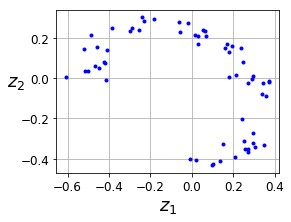

In [22]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
#save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked autoencoders

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [29]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, input_shape=[30], activation='selu'),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_model = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [30]:
stacked_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_9 (Sequential)    (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [31]:
stacked_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5))

In [33]:
history = stacked_model.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 112us/sample - loss: 0.3352 - val_loss: 0.3155
Epoch 2/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.3037 - val_loss: 0.3007
Epoch 3/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.2967 - val_loss: 0.2961
Epoch 4/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.2927 - val_loss: 0.2927
Epoch 5/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.2900 - val_loss: 0.2908
Epoch 6/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.2882 - val_loss: 0.2884
Epoch 7/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.2867 - val_loss: 0.2873
Epoch 8/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.2856 - val_loss: 0.2864
Epoch 9/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.2848 - val_

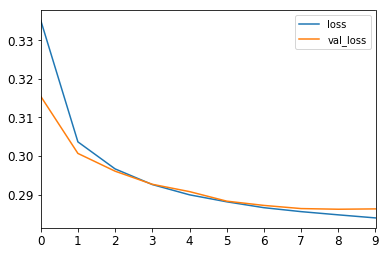

In [46]:
pd.DataFrame(history.history).plot()

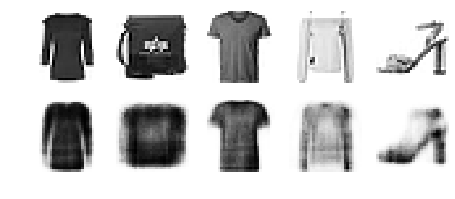

In [36]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_model)

In [37]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

In [40]:
X_valid_compressed.shape

(5000, 30)

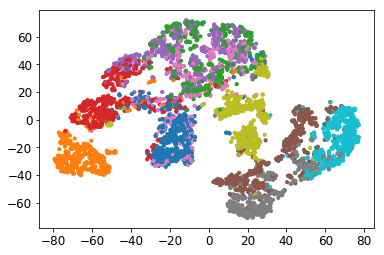

In [38]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")

In [39]:
y_valid

array([0, 8, 0, ..., 3, 0, 5], dtype=uint8)

# Unsupervised Pretraining Using Stacked Autoencoders
